### Required imports

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
import pyphi # needs nonbinary install
pyphi.config.PARTITION_TYPE = 'ALL'
pyphi.config.MEASURE = 'AID'
pyphi.config.USE_SMALL_PHI_DIFFERENCE_FOR_CES_DISTANCE = True
pyphi.config.ASSUME_CUTS_CANNOT_CREATE_NEW_CONCEPTS = True
pyphi.config.WELCOME_OFF = True

from temporal_emergence import TPMMaker, CoarseGrainer, PhiCalculator, DataGenerator, Helpers


Welcome to PyPhi!

If you use PyPhi in your research, please cite the paper:

  Mayner WGP, Marshall W, Albantakis L, Findlay G, Marchman R, Tononi G.
  (2018). PyPhi: A toolbox for integrated information theory.
  PLOS Computational Biology 14(7): e1006343.
  https://doi.org/10.1371/journal.pcbi.1006343

Documentation is available online (or with the built-in `help()` function):
  https://pyphi.readthedocs.io

To report issues, please use the issue tracker on the GitHub repository:
  https://github.com/wmayner/pyphi

For general discussion, you are welcome to join the pyphi-users group:
  https://groups.google.com/forum/#!forum/pyphi-users

To suppress this message, either:
  - Set `WELCOME_OFF: true` in your `pyphi_config.yml` file, or
  - Set the environment variable PYPHI_WELCOME_OFF to any value in your shell:
        export PYPHI_WELCOME_OFF='yes'



### Loading data for neurons 143, 168

In [2]:
times = np.squeeze(np.load("Cori_2016-12-14/spikes.times.npy"))
clusters = np.squeeze(np.load("Cori_2016-12-14/spikes.clusters.npy"))
probe = np.squeeze(np.load("Cori_2016-12-14/clusters.probes.npy"))

minindex = min(clusters)
maxindex = max(clusters)

# split data into individual neuron arrays
individual_times = []
for i in range(minindex, maxindex+1):
    indices = np.where(clusters==i)[0]
    individual_times.append(times[indices].astype(float))

# get only the good neurons
annotations = np.squeeze(np.load("Cori_2016-12-14/clusters._phy_annotation.npy"))
good_indices = np.where(annotations >= 2)
good_neurons = np.array(individual_times)[good_indices].tolist()

probe1_indices = np.nonzero(probe)[0]
good_indices_probe1 = np.intersect1d(good_indices,probe1_indices)
print(good_indices_probe1.shape)
good_neurons_probe1 = np.array(individual_times)[good_indices_probe1]

n_143 = good_neurons_probe1[143]
n_168 = good_neurons_probe1[168]

(371,)
ipykernel_launcher:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
ipykernel_launcher:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


### Get a nonbinary TPM for neurons 143, 168

In [15]:
good_neurons_probe1.shape

(371,)

In [5]:
neurons = [143,168]
cluster_143_168 = good_neurons_probe1[neurons]
#TPM = TPMMaker.TPM_from_spiketrains(cluster_143_168,0.005,2,2,2000)

### Coarse grain it to get the macro

In [7]:
num_states_per_elem = [2,2]
state_map = {0: [0,1,2, 4,5,6, 8,9,10], 1: [3,7,11], 2: [12,13,14], 3:[15]}
macro_TPM = CoarseGrainer.coarse_grain_nonbinary_TPM(TPM[0], state_map, num_states_per_elem)

### Do this repeatedly for different samples of the 143,168 data to plot the difference in Phi values.

In [12]:
micro_phis = []
macro_phis = []
for _ in range(10):
    num_transitions = 2000
    TPM,_ = TPMMaker.TPM_from_spiketrains(cluster_143_168,0.005,2,2,num_transitions)
    #np.savetxt("TPMs/micro_example_143_168.csv", TPM)
    micro_phis.append(PhiCalculator.get_micro_average_phi(TPM, verbose=False))
    macro_phis.append(PhiCalculator.get_macro_average_phi(TPM, verbose=False))
print(micro_phis, macro_phis)

                                                                [0.0046673125, 0.0025306874999999973, 0.005074750000000002, 0.006474000000000004, 0.005469312499999997, 0.006858500000000008, 0.0046015625, 0.006047750000000003, 0.005919000000000001, 0.005364375000000003] [0.0032237499999999975, 0.0021702499999999986, 0.0008585000000000051, 0.0, 0.0, 0.0007479999999999917, 0.0, 0.00039150000000000296, 0.0, 0.0007169999999999954]


([<matplotlib.axis.XTick at 0x1294c3e48>,
 <a list of 2 Text xticklabel objects>)

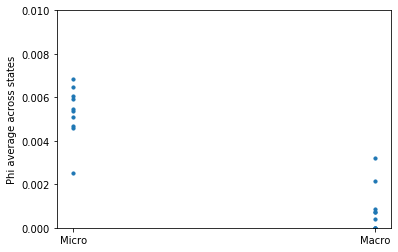

In [13]:
plt.scatter([1 for _ in range(10)] + [2 for _ in range(10)],[micro_phis,macro_phis],s=10)
plt.ylim([0,0.01])
plt.ylabel("Phi average across states")
plt.xticks([1,2],["Micro", "Macro"])

### Now analyse for varying parameters. Varying skip and varying size of micro bin.

In [6]:
NUM_BITS = 2
skips = list(range(2,11,2))

max_binsize = 0.02  # 50 ms bins
min_binsize = 0.001 # 1ms bins  -   probably won't work
num_binsizes = 10
binsizes = [0.02]#np.linspace(min_binsize, max_binsize, num_binsizes)


num_transitions = 200
micro_phis = np.zeros((len(binsizes), len(skips)))
macro_phis = np.zeros((len(binsizes), len(skips)))

for i in range(len(binsizes)):
    binsize = binsizes[i]
    for j in range(len(skips)):
        skip = skips[j]

        try:
            TPM,_ = TPMMaker.TPM_from_spiketrains(cluster_143_168,binsize,NUM_BITS,skip,num_transitions)
            tpmname = "micro_143_168_bin_"+str(binsize)+"_skip_"+str(skip)+".csv" 
            np.savetxt("TPMs/"+tpmname, TPM)
            success = True
        except:
            success = False
            print("Failed for binsize: " + str(binsize) + " and skip: " + str(skip))
        
        if success:
            micro_phis[i,j] = PhiCalculator.get_micro_average_phi(TPM, verbose=False)
            macro_phis[i,j] = PhiCalculator.get_macro_average_phi(TPM, verbose=False)
            macros = PhiCalculator.all_coarsegrains_get_macro_average_phi(TPM, verbose=False)
            print(macros)
            print("Success for binsize: " + str(binsize) + " and skip: " + str(skip))
        
        else:
            micro_phis[i,j] = None
            macro_phis[i,j] = None


KeyError: 3

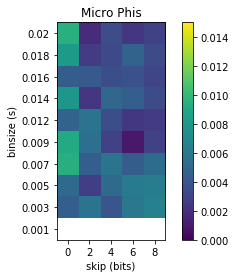

<Figure size 432x288 with 0 Axes>

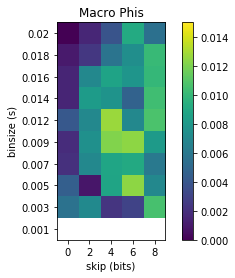

In [39]:
skips_corrected = [s - 2 for s in skips]

fig, ax = plt.subplots()

plt.imshow(micro_phis, vmin=0, vmax=0.015)
plt.title("Micro Phis")
plt.xlabel("skip (bits)")
plt.xticks(ticks=range(len(skips_corrected)), labels=skips_corrected)

plt.ylabel("binsize (s)")
roundedbinsizes = np.round(binsizes, 3)
plt.yticks(ticks=range(len(binsizes)), labels=roundedbinsizes)
ax.set_ylim(-0.5, 9.5)

plt.colorbar()


plt.figure()
fig, ax = plt.subplots()

plt.imshow(macro_phis, vmin=0, vmax=0.015)
plt.title("Macro Phis")
plt.xlabel("skip (bits)")
plt.xticks(ticks=range(len(skips_corrected)), labels=skips_corrected)

plt.ylabel("binsize (s)")
roundedbinsizes = np.round(binsizes, 3)
plt.yticks(ticks=range(len(binsizes)), labels=roundedbinsizes)
ax.set_ylim(-0.5, 9.5)

plt.colorbar()



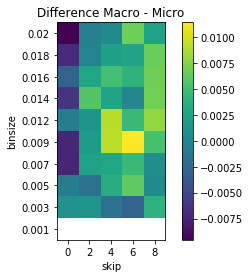

In [36]:
# and plot the difference
diff_macro_micro = macro_phis - micro_phis

fig, ax = plt.subplots()

plt.imshow(diff_macro_micro) #vmin=-0.015, vmax=0.015)
plt.title("Difference Macro - Micro")
plt.xlabel("skip")
plt.xticks(ticks=range(len(skips_corrected)), labels=skips_corrected)

plt.ylabel("binsize")
roundedbinsizes = np.round(binsizes, 3)
plt.yticks(ticks=range(len(binsizes)), labels=roundedbinsizes)
ax.set_ylim(-0.5, 9.5)

plt.colorbar()


In [42]:
pyphi.config.PROGRESS_BARS = False

In [45]:
# Same as above but many repetitions
NUM_BITS = 2
REPS = 20

skips = list(range(2,11,2))

max_binsize = 0.02  # 50 ms bins
min_binsize = 0.001 # 1ms bins  -   probably won't work
num_binsizes = 10
binsizes = np.linspace(min_binsize, max_binsize, num_binsizes)

num_transitions = 1000
micro_phis_reps = np.zeros((len(binsizes), len(skips), REPS))
macro_phis_reps = np.zeros((len(binsizes), len(skips), REPS))

for rep in range(REPS):
    for i in range(len(binsizes)):
        binsize = binsizes[i]
        for j in range(len(skips)):
            skip = skips[j]

            try:
                TPM,_ = TPMMaker.TPM_from_spiketrains(cluster_143_168,binsize,NUM_BITS,skip,num_transitions)
                tpmname = "micro_143_168_bin_"+str(binsize)+"_skip_"+str(skip)+str(rep)+".csv" 
                np.savetxt("TPMs/"+tpmname, TPM)
                success = True
            except:
                success = False
                print("Failed for binsize: " + str(binsize) + " and skip: " + str(skip))
            
            if success:
                micro_phis_reps[i,j, rep] = PhiCalculator.get_micro_average_phi(TPM, verbose=False)
                macro_phis_reps[i,j, rep] = PhiCalculator.get_macro_average_phi(TPM, verbose=False)
                print("Success for binsize: " + str(binsize) + " and skip: " + str(skip))
            
            else:
                micro_phis_reps[i,j, rep] = None
                micro_phis_reps[i,j, rep] = None


Failed for binsize: 0.001 and skip: 2
Failed for binsize: 0.001 and skip: 4
Failed for binsize: 0.001 and skip: 6
Failed for binsize: 0.001 and skip: 8
Failed for binsize: 0.001 and skip: 10
Success for binsize: 0.003111111111111111 and skip: 2
Success for binsize: 0.003111111111111111 and skip: 4
Success for binsize: 0.003111111111111111 and skip: 6
Success for binsize: 0.003111111111111111 and skip: 8
Success for binsize: 0.003111111111111111 and skip: 10
Success for binsize: 0.005222222222222222 and skip: 2
Success for binsize: 0.005222222222222222 and skip: 4
Success for binsize: 0.005222222222222222 and skip: 6
Success for binsize: 0.005222222222222222 and skip: 8
Success for binsize: 0.005222222222222222 and skip: 10
Success for binsize: 0.007333333333333333 and skip: 2
Success for binsize: 0.007333333333333333 and skip: 4
Success for binsize: 0.007333333333333333 and skip: 6
Success for binsize: 0.007333333333333333 and skip: 8
Success for binsize: 0.007333333333333333 and skip:

KeyboardInterrupt: 

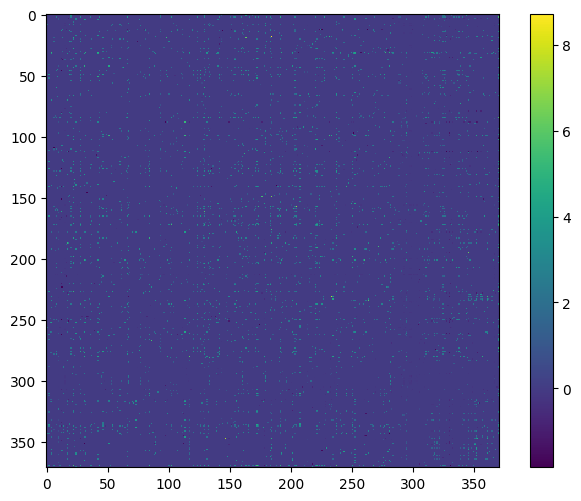

In [17]:
# Load connection matrix of 371 neurons from probe 1, cori recording 1. 
# Computed using default parameter settings for GLMCC
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=100)

probe1_371 = np.loadtxt("results/connectivity_Cori_2016-12-14_probe1/W_py_5400.csv", delimiter=",")
plt.imshow(probe1_371)
plt.colorbar()

In [18]:
# get tuples of connected neurons
ai,bi = np.where(abs(probe1_371) != 0)
index_pairs = list(zip(ai,bi))

a,b = np.where((probe1_371) > 0)
index_pairs_excitatory = list(zip(a,b))

a,b = np.where((probe1_371) < 0)
index_pairs_inhibitory = list(zip(a,b))


print("Proportion of non-null connections: " + str(len(index_pairs) / 371**2 * 2))
print("Number of connections: " + str(len(index_pairs)))
print("\tProportion of connections that are excitatory: " + str(len(index_pairs_excitatory)/len(index_pairs)))
print("\tProportion of connections that are inhibitory: " + str(len(index_pairs_inhibitory)/len(index_pairs)))

Proportion of non-null connections: 0.06550373798504806
Number of connections: 4508
	Proportion of connections that are excitatory: 0.8469387755102041
	Proportion of connections that are inhibitory: 0.15306122448979592


In [15]:
import networkx as nx
from pyvis import physics
from pyvis import network
G = nx.from_numpy_matrix(probe1_371, parallel_edges=False)

net = network.Network()
net.from_nx(G)
net.toggle_physics(True)
net.repulsion(node_distance=1000, central_gravity=0, spring_length=200, spring_strength=0.05, damping=0.09)
net.show('probe1_cori.html')

In [37]:
# Find the minimum PSP value of a connection and its corresponding neuron pair, then produce the GLMCC plot for it. 
abs_probe1_371 = abs(probe1_371)
mini,minj = np.where(abs_probe1_371==np.min(abs_probe1_371[np.nonzero(abs_probe1_371)])) 
maxi, maxj = np.where(abs_probe1_371==np.max(abs_probe1_371[np.nonzero(abs_probe1_371)])) 

In [8]:
# SORT THE NEURON INDICES BY MAX INPUT AND MIN INPUT
max_in, max_out, min_in, min_out = [],[],[],[]
for i in range(probe1_371.shape[0]):
    outputs = probe1_371[i, :]
    max_out.append(max(outputs))
    min_out.append(min(outputs))

    inputs = probe1_371[:, i]
    max_in.append(max(inputs))
    min_in.append(min(inputs))

indices = list(range(371))
max_in_sort = [x for _, x in sorted(zip(max_in, indices))]
max_out_sort = [x for _, x in sorted(zip(max_out, indices))]
min_in_sort = [x for _, x in sorted(zip(min_in, indices))]
min_out_sort = [x for _, x in sorted(zip(min_out, indices))]

In [7]:
# Generate the ISIs
import matplotlib.pyplot as plt

for i in max_in_sort:
    spikes = good_neurons_probe1[i]
    diff_spikes = np.diff(spikes) * 1000
    #bin_limits = np.linspace(0, 10000, 100)
    logbins = np.logspace(0,5,100)
    plt.hist(diff_spikes, bins=logbins)
    plt.xlabel("Interspike interval (ms)")
    plt.ylabel("Frequency")
    plt.title("ISI for neuron " + str(i))
    plt.xscale('log')
    plt.savefig("Cori_2016-12-14_probe1_isis/neuron_"+str(i)+".png")    
    plt.close()
    

In [ ]:
## PERFORM KS TEST ON THE ISIs, using a lognormal distribution
from scipy.stats import kstest, normaltest, lognorm
stats = []
for spikes in good_neurons_probe1:
    isi = np.diff(spikes)
    lognorm_fit = lognorm.fit(isi)
    print(lognorm_fit)
    k = kstest(np.array(isi), lognorm_fit, [1])
    stats.append(k[0])
plt.hist(stats, bins=30)
plt.xlabel("KS-statistic")
plt.ylabel("Frequency")
plt.title("KS-statistic of logged ISIs against normal distribution")
plt.figure()
np.argmin(stats)

In [31]:
# manual filtering of log-ISIs produces list of neurons which tend to burst.
indices = np.array([48,105,199,222,299,304,363,366,318,16,302,347,187,30,6,326,359,150,312,362,306,13,325,107,88,259,316,336,120,251,19,332,335,66,343,99,322,234,126,352,120,277,260,86,117,163,345])

In [5]:
# get the connectivity between these bursting neurons
bursting_neurons_connectivity = probe1_371[indices[:, None], indices]
connections = np.where(abs(bursting_neurons_connectivity) > 0)

reference = indices[connections[0]]
target = indices[connections[1]]

# find bidirectionally connected pairs, inneficiently.
# can be done faster by adding the two arrays element-wise, where the second array is multiplied by 10, 
# and then sorting the array. duplicate values then indicate bidirectionality. 
r_ts = []
for i in range(len(reference)):
    r = reference[i]
    t = target[i]
    r_ts.append((r,t))

bidirectionally = []
for (r,t) in r_ts:
    if (t,r) in r_ts and (t,r) not in bidirectionally:
        bidirectionally.append((r,t))

bidirectionally


IndexError: index 3661 is out of bounds for axis 0 with size 371

In [3]:
for (i,j) in bidirectionally:
    print(probe1_371[i,j], probe1_371[j,i])
for (i,_) in bidirectionally:
    print(i)

NameError: name 'bidirectionally' is not defined

In [29]:
# VISUALISATION, bidirectionally connected bursting neurons
import networkx as nx
from pyvis import physics
from pyvis import network

G = network.Network()

for (i,j) in bidirectionally:
    G.add_node(int(i))
    G.add_node(int(j))
    G.add_edge(int(i),int(j))
    G.add_edge(int(j),int(i))

G.show('bidirectional_bursting.html')

In [9]:
## GET THE PHIS FOR A PARTICULAR NEURON PAIR

import numpy as np
def get_phis(i,j, folder, outfolder, num_transitions=1000):

    ### LOAD DATASET ###

    i_msec = np.loadtxt(folder + "/cell" + str(i) + ".txt") / 1000   # divide through as they are loaded in seconds
    j_msec = np.loadtxt(folder + "/cell" + str(j) + ".txt") / 1000
    cluster = np.array([i_msec, j_msec])

    ### PARAMETERS ###

    NUM_BITS = 2

    skips = [2]#list(range(2,11,2))

    max_binsize = 0.02  # 50 ms bins
    min_binsize = 0.001 # 1ms bins  -   probably won't work
    num_binsizes = 10
    binsizes = [0.02]#np.linspace(min_binsize, max_binsize, num_binsizes)

    ### COMPUTE PHIS ###

    micro_phis = np.zeros((len(binsizes), len(skips)))
    NUM_COARSE_GRAININGS = 16
    macro_phis = np.zeros((len(binsizes), len(skips), NUM_COARSE_GRAININGS))

    for i in range(len(binsizes)):
        binsize = binsizes[i]
        for j in range(len(skips)):
            skip = skips[j]

            #try:
            TPM,_ = TPMMaker.TPM_from_spiketrains(cluster,binsize,NUM_BITS,skip,num_transitions)
            tpmname = "micro_" + str(i) + "_" + str(j) + "_bin_"+str(binsize)+"_skip_"+str(skip)+".csv" 
            np.savetxt(outfolder+"/"+tpmname, TPM)
            success = True
            #except:
            #    success = False
            #    print("Failed for binsize: " + str(binsize) + " and skip: " + str(skip))
            
            if success:
                micro_phis[i,j] = PhiCalculator.get_micro_average_phi(TPM, verbose=False)
                macro_phis[i,j] = PhiCalculator.all_coarsegrains_get_macro_average_phi(TPM, verbose=False)
                print("Success for binsize: " + str(binsize) + " and skip: " + str(skip))
            
            else:
                micro_phis[i,j] = None
                macro_phis[i,j] = None
    return (micro_phis, macro_phis)

In [12]:
#phis = get_phis(298, 301, "GLMCC/Cori_2016-12-14_probe1", "results/TPMs_298_301", num_transitions=200)
## GET THE MACRO TPMS
state_maps, num_states = CoarseGrainer.get_state_maps([[[0], [1,2,3]], [[0,1,2],[3]], [[0], [1,2],[3]], [[0],[1],[2],[3]]])
micro_TPM = np.loadtxt("results/TPMs_298_301/micro_0_0_bin_0.02_skip_2.csv")
macro_TPMs = []
for i in range(len(state_maps)):
    state_map = state_maps[i] 
    num_state = num_states[i]
    macro_TPM_i = CoarseGrainer.coarse_grain_nonbinary_TPM(micro_TPM, state_map, num_state)
    macro_TPMs.append(macro_TPM_i)

In [15]:
phis[0]

array([[0.00368488]])

/Users/Marcel/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


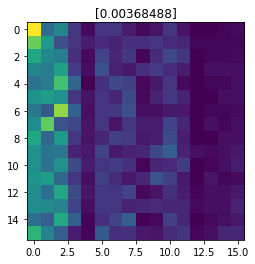

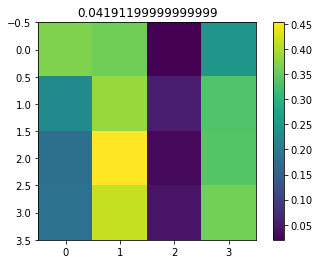

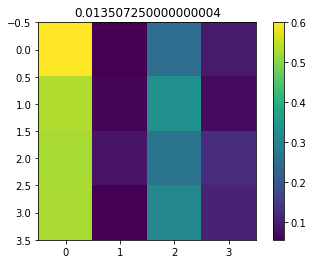

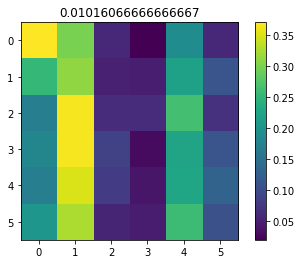

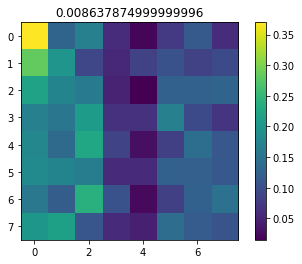

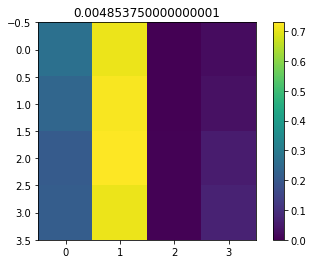

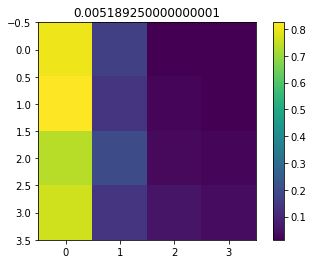

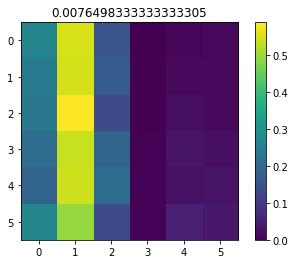

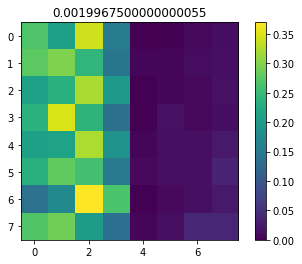

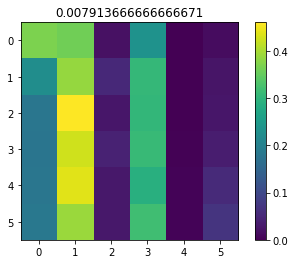

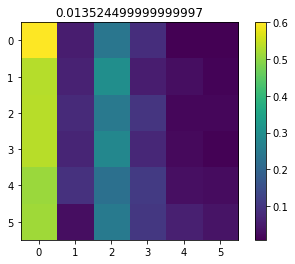

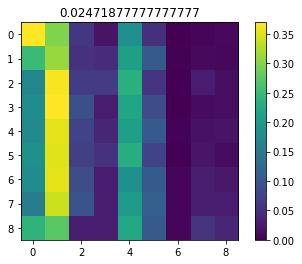

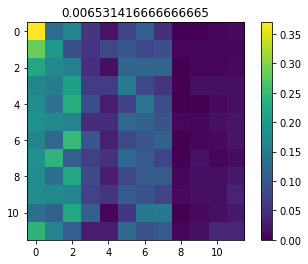

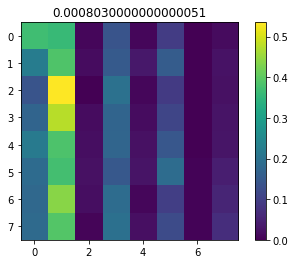

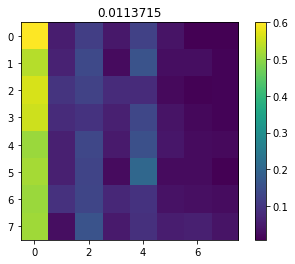

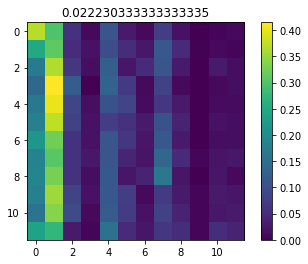

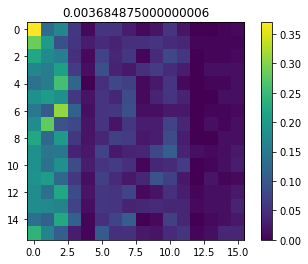

In [29]:
## MICRO TPM
plt.imshow(micro_TPM)
plt.title(phis[0][0])
## PLOT THE MACRO TPMS
macro_phis = np.squeeze(phis[1])
for i in range(len(macro_TPMs)):
    macro_TPM = macro_TPMs[i]
    plt.figure()
    plt.imshow(macro_TPM)
    plt.title(str(macro_phis[i]))
    plt.colorbar()

In [14]:
print(phis)

(array([[0.00532862]]), array([[[0.07812   , 0.0049995 , 0.0289915 , 0.0255395 , 0.0025715 ,
         0.005204  , 0.00725083, 0.013063  , 0.04297878]]]))


Text(0.5, 1.0, 'Cumulative incoming connections\n for neurons in probe 1')

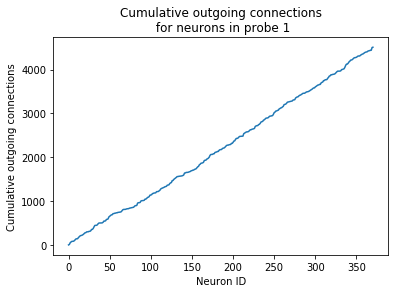

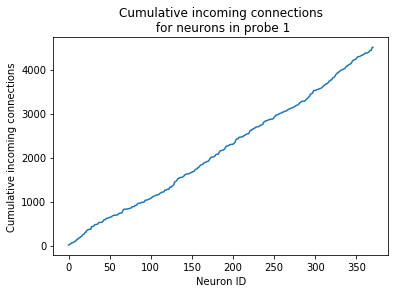

In [44]:
# CUMULATIVE HISTOGRAM, % of connections to other neurons within probe

# CUMULATIVE HISTOGRAM, outgoing connections
num_out = np.count_nonzero(probe1_371, 1)
cumul_sum_num_out = np.cumsum(num_out)
plt.plot(cumul_sum_num_out)
plt.xlabel("Neuron ID")
plt.ylabel("Cumulative outgoing connections")
plt.title("Cumulative outgoing connections\n for neurons in probe 1")
#plt.plot(cumul_sum_num_out)
# CUMULATIVE HISTOGRAM, incoming connections
num_in = np.count_nonzero(probe1_371, 0)
cumul_sum_num_in = np.cumsum(num_in)
plt.figure()
plt.plot(cumul_sum_num_in)
plt.xlabel("Neuron ID")
plt.ylabel("Cumulative incoming connections")
plt.title("Cumulative incoming connections\n for neurons in probe 1")

#plt.plot(cumul_sum_num_in)


Text(0, 0.5, 'Number of incoming connections')

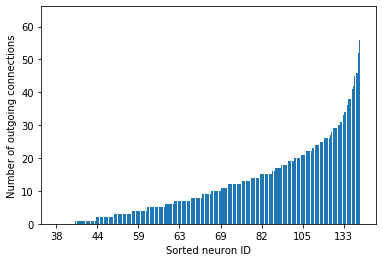

<Figure size 432x288 with 0 Axes>

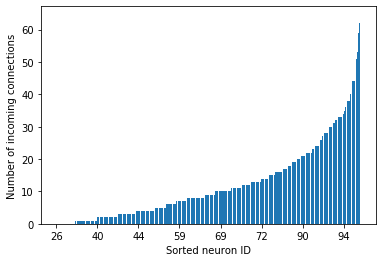

In [52]:
# SAME BUT SORTED

xes_sorted_out = [x for _, x in sorted(zip(num_out, range(371)))]
xes_sorted_in = [x for _, x in sorted(zip(num_in, range(371)))]
fig, ax = plt.subplots()
ax.bar(range(371), sorted(num_out))
ax.set_xticklabels(xes_sorted_out)
ax.set_xlabel("Sorted neuron ID")
ax.set_ylabel("Number of outgoing connections")

plt.figure()

fig, ax = plt.subplots()
ax.bar(range(371), sorted(num_in))
ax.set_xticklabels(xes_sorted_in)
ax.set_xlabel("Sorted neuron ID")
ax.set_ylabel("Number of incoming connections")



0.9217432907774826
0.621996460290198
0.6521585556249561
0.7590553894488506
0.7762538725209416
0.7960742119998737
0.8258672180286072
0.8982093570900698
0.5517407009925175
0.7647578484625824
0.7693093642211384
0.8494112471308345
0.8631716756694926
0.8583666945617836
0.6501823717209358
0.7071803771886982
0.9777309272752681
0.503793804521205
0.5383074060106825
0.8987733103620036
0.8685421385786576
0.6527338616560985
0.6538658270618991
0.7085653753949728
0.7291323722325183
0.797850651693101
0.8593119281089459
0.6895559533504436
0.6892243785745583
0.6734335825482225
0.7602240839316231
0.8940951217497686
0.6767706639423496
0.8089585814487383
0.8180264167589395
0.8717761311856852
0.870291809085383
0.8687192812442506
0.8667714180167319
0.8717771597025579
0.6594727966150493
0.8296981687394911
0.8733731772076465
0.8717566287032525
0.5240487502165372
0.6587415016842895
0.7536514324494396
0.7522006264310375
0.5981160980341659
0.9012248804302538
0.9068803716466021
0.509007234553303
0.576462552111234

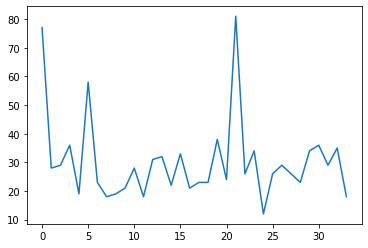

In [9]:
## GET THE THROUGHS of the bursting neurons
from separating_threshold import is_bursting
import matplotlib.pyplot as plt
mins = []
for i in indices:
    path = "GLMCC/Cori_2016-12-14_probe1/cell" + str(i) + ".txt"
    bursts, data = is_bursting(path)
    if bursts:
        _, _,min_x, _ = data
        mins.append(min_x)
plt.plot(mins)

In [14]:
### Using the trough x value to determine the temporal scale of the bursts
# TODO

In [19]:
### FIND ALL BIDIRECTIONALLY CONNECTED NEURON PAIRS, filter by firing rates
bidirectionally = []
for (r,t) in index_pairs:
    if (t,r) in index_pairs and (t,r) not in bidirectionally:
        bidirectionally.append((r,t))


In [22]:
flattened = list(set([item for sublist in bidirectionally for item in sublist]))
print(len(flattened))

284


5.064518633549242


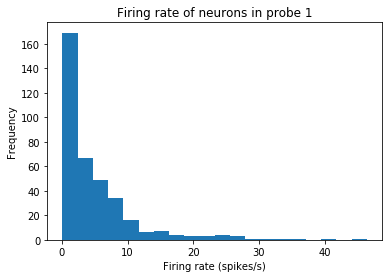

In [110]:
### FILTER NEURONS BY FIRING RATE
def firing_rate(index):
    spikes = good_neurons_probe1[index]
    return len(spikes)/(spikes[-1] - spikes[0])

high_firing_bidirecitonal = []
for i,j in bidirectionally:
    if firing_rate(i) > 10 and firing_rate(j) > 10:
        high_firing_bidirecitonal.append((i,j))

# put them in a file for massive
filename = "high_firing_bidirectional.txt"
with open(filename, 'w') as f:
    for (i,j) in high_firing_bidirecitonal:
        f.write(str(i) + " " + str(j) + "\n")

firing_rates = []
for i in range(371):
    firing_rates.append(firing_rate(i))
plt.hist(firing_rates, bins=20)
plt.title("Firing rate of neurons in probe 1")
plt.xlabel("Firing rate (spikes/s)")
plt.ylabel("Frequency")

print(np.sum(firing_rates)/len(firing_rates))

In [62]:
FILE = "results/PHIS/"
OUT = "results/PHIS_plots/"
max_binsize = 0.02  # 50 ms bins
min_binsize = 0.001 # 1ms bins  -   probably won't work
num_binsizes = 10
binsizes = np.linspace(min_binsize, max_binsize, num_binsizes)

skips = list(range(2,11,2))
skips_corrected = [s - 2 for s in skips]

for (i,j) in high_firing_bidirecitonal:
    micro_phis = np.loadtxt(FILE + "micro_" + str(i) + "_" + str(j))
    macro_phis = np.loadtxt(FILE + "macro_" + str(i) + "_" + str(j))
    maxval = np.max([np.nanmax(micro_phis),np.nanmax(macro_phis)])

    fig, (ax1, ax2) = plt.subplots(1, 2)

    im = ax1.imshow(micro_phis, vmin=0, vmax=maxval)
    ax1.set_title("Micro Phis" + str(i) + "_" + str(j))
    ax1.set_xlabel("skip (bits)")
    ax1.set_xticks(ticks=range(len(skips_corrected)))
    ax1.set_xticklabels(labels=skips_corrected)
    ax1.set_ylabel("binsize (s)")
    roundedbinsizes = np.round(binsizes, 3)
    ax1.set_yticks(ticks=range(len(binsizes)))
    ax1.set_yticklabels(labels=roundedbinsizes)
    ax1.set_ylim(-0.5, 9.5)

    im = ax2.imshow(macro_phis, vmin=0, vmax=maxval)
    ax2.set_title("Macro Phis" + str(i) + "_" + str(j))
    ax2.set_xlabel("skip (bits)")
    ax2.set_xticks(ticks=range(len(skips_corrected)))
    ax2.set_xticklabels(labels=skips_corrected)

    ax2.set_ylabel("binsize (s)")
    roundedbinsizes = np.round(binsizes, 3)
    ax2.set_yticks(ticks=range(len(binsizes)))
    ax2.set_yticklabels(labels=roundedbinsizes)

    ax2.set_ylim(-0.5, 9.5)

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    plt.savefig(OUT+"macro_micro_" + str(i) + "_" + str(j))
    plt.close()



OSError: results/PHIS/micro_296_366 not found.